In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

In [2]:
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

# Loading & Visualization

In [3]:
df = pd.read_csv("data/planet\planet/train_classes.csv") # Adjust as needed
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [70]:
all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)
print(all_tags)

{'blooming', 'road', 'partly_cloudy', 'slash_burn', 'blow_down', 'cloudy', 'agriculture', 'haze', 'habitation', 'bare_ground', 'clear', 'primary', 'artisinal_mine', 'selective_logging', 'water', 'conventional_mine', 'cultivation'}


In [5]:
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17


## Imbalance Metrics

In [ ]:
# Based on https://link.springer.com/chapter/10.1007/978-3-642-40846-5_16 

# Calculate h(y, Yi)
def h(y, Yi):
    return 1 if y in Yi else 0

# Calculate IRperLabel for each label y
def calculate_IRperLabel(all_labels, df):
    IR = {}
    # Split tags into lists of labels
    df['label_list'] = df['tags'].apply(lambda x: x.split())
    
    for y in all_labels:
        label_counts = [sum(h(y, Yi) for Yi in df['label_list'])]
        majority_label_count = sum(label_counts)
        
        # Get the number of labels in the dataset
        IR[y] = majority_label_count / len(df) if len(df) > 0 else 0

    return IR

# Calculate MeanIR (average imbalance ratio)
def calculate_MeanIR(IR):
    return np.mean(list(IR.values()))

# Calculate CVIR (coefficient of variation of imbalance ratio)
def calculate_CVIR(IR, MeanIR):
    mean_squared_diff = np.mean([(val - MeanIR)**2 for val in IR.values()])
    return np.sqrt(mean_squared_diff) / MeanIR if MeanIR != 0 else 0


IRperLabel: {'blooming': 0.00820178364090022, 'road': 0.1993873366436918, 'partly_cloudy': 0.1793769608933027, 'slash_burn': 0.005163171026952247, 'blow_down': 0.0024210084241211493, 'cloudy': 0.05160700610192939, 'agriculture': 0.3042318239086934, 'haze': 0.06662713999851776, 'habitation': 0.090417253390647, 'bare_ground': 0.021294992465228885, 'clear': 0.702364188838657, 'primary': 0.9267274389189456, 'artisinal_mine': 0.00837471281405173, 'selective_logging': 0.008399416981644803, 'water': 0.18308258603226366, 'conventional_mine': 0.002470416759307295, 'cultivation': 0.11060055831418761}
MeanIR: 0.16886751736194366
CVIR: 1.5019480501275149


C:\Users\xxpur\AppData\Local\Temp\ipykernel_32304\2573084261.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


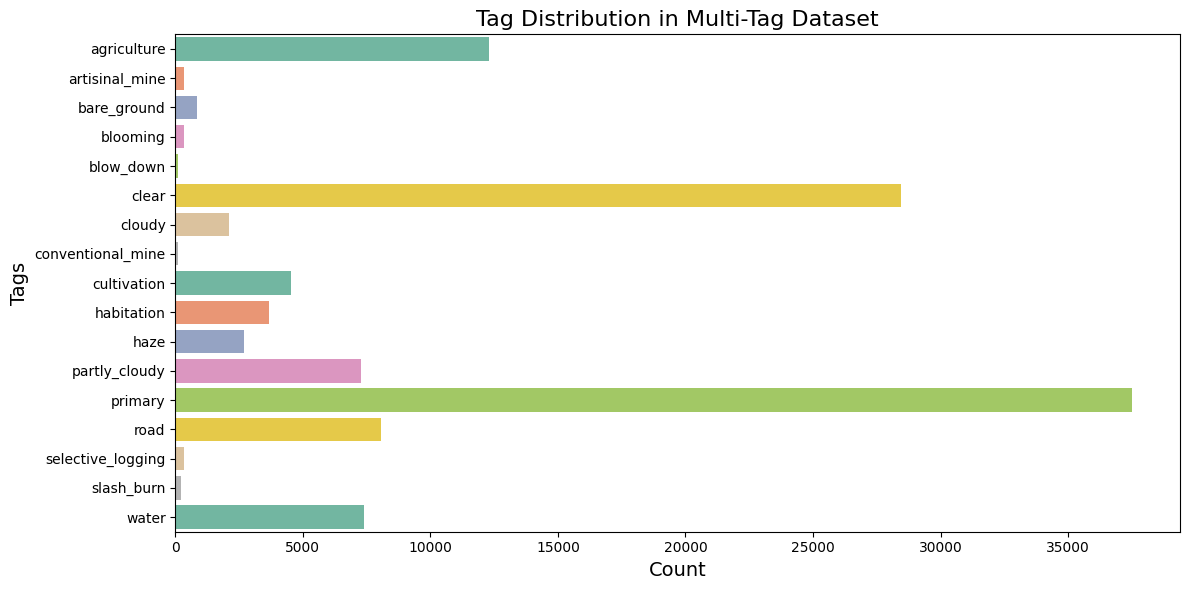

Standard Deviation of Tag Frequencies: 37670.58183190001


In [ ]:
def plot_spread(data):
    # Flatten the list of labels
    all_tags = data['tags'].apply(lambda x: x.split() if isinstance(x, str) else x)
    flattened_tags = [tag for sublist in all_tags for tag in sublist]

    # Convert to a DataFrame for easy handling
    tag_df = pd.DataFrame(flattened_tags, columns=['tag'])

    # Sort tags alphabetically
    sorted_tag_counts = tag_df['tag'].value_counts().sort_index()  # Sort alphabetically by tag
    sorted_tag_df = pd.DataFrame({'tag': sorted_tag_counts.index, 'count': sorted_tag_counts.values})

    # Plot the distribution horizontally
    plt.figure(figsize=(12, 6))  # Increase figure size to accommodate labels
    sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data

    # Add labels and title
    plt.title('Tag Distribution in Multi-Tag Dataset', fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Tags', fontsize=14)

    # Adjust label sizes and positioning
    plt.tight_layout()

    # Display the plot
    plt.show()

def get_std_dev(data):
    tag_counts = Counter(tag for tags in data['tags'] for tag in tags)
    frequencies = list(tag_counts.values())
    imbalance_std = np.std(frequencies)
    print(f"Standard Deviation of Tag Frequencies: {imbalance_std}")

plot_spread(df)
get_std_dev(df)
IR = calculate_IRperLabel(all_tags, df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

# Generation

In [186]:
# Create validation group before anything happens
train, val = train_test_split(df, test_size=0.1)
print(train.shape)
print(val.shape)

(36431, 3)
(4048, 3)


In [187]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # if type(csv_file) != str:
        #     self.df = csv_file
        # else:
        #     self.df = pd.read_csv(csv_file)
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        tags = self.df.iloc[idx, 1].split()
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

In [ ]:
import albumentations as A
import cv2

image_augmentation_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

## Undersampling

### Label Powerset based Random Undersampling (LP-RUS)

#### Setup (For both LP-RUS and LP-ROS)

In [188]:
from skmultilearn.problem_transform import LabelPowerset

X = train["image_name"].values
y = train["tags"].values
y_binary = np.zeros((len(y), len(tag_to_idx)), dtype=int)

# Populate the binary matrix
for i, tags in enumerate(y):
    for tag in tags.split():  # Split tags by space
        tag_id = tag_to_idx[tag]
        y_binary[i, tag_id] = 1

print(y_binary.shape)
#print(y[0])
X = X.reshape(-1, 1)
print(X.shape)

lp = LabelPowerset()
X_transformed = X
y_transformed = lp.transform(y_binary)
print(X_transformed.shape)
y_transformed = y.reshape(-1,1)
print(y_transformed.shape)

(36431, 17)
(36431, 1)
(36431, 1)
(36431, 1)


In [189]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
ros = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = ros.fit_resample(X_transformed, y_transformed)

df_undersampled = pd.DataFrame(X_undersampled)

# Add the decoded labels as a column to the DataFrame
df_undersampled['tags'] = y_undersampled
print(df_undersampled)

               0                                               tags
0    train_20674  agriculture artisinal_mine bare_ground clear p...
1    train_23966  agriculture artisinal_mine bare_ground clear p...
2     train_9528  agriculture artisinal_mine clear conventional_...
3     train_2667  agriculture artisinal_mine clear cultivation h...
4     train_1340  agriculture artisinal_mine clear cultivation h...
..           ...                                                ...
429   train_6379                   partly_cloudy primary slash_burn
430  train_18547                        partly_cloudy primary water
431    train_340                           partly_cloudy road water
432  train_10780                                partly_cloudy water
433  train_24448                                              water

[434 rows x 2 columns]


C:\Users\xxpur\AppData\Local\Temp\ipykernel_32304\2573084261.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


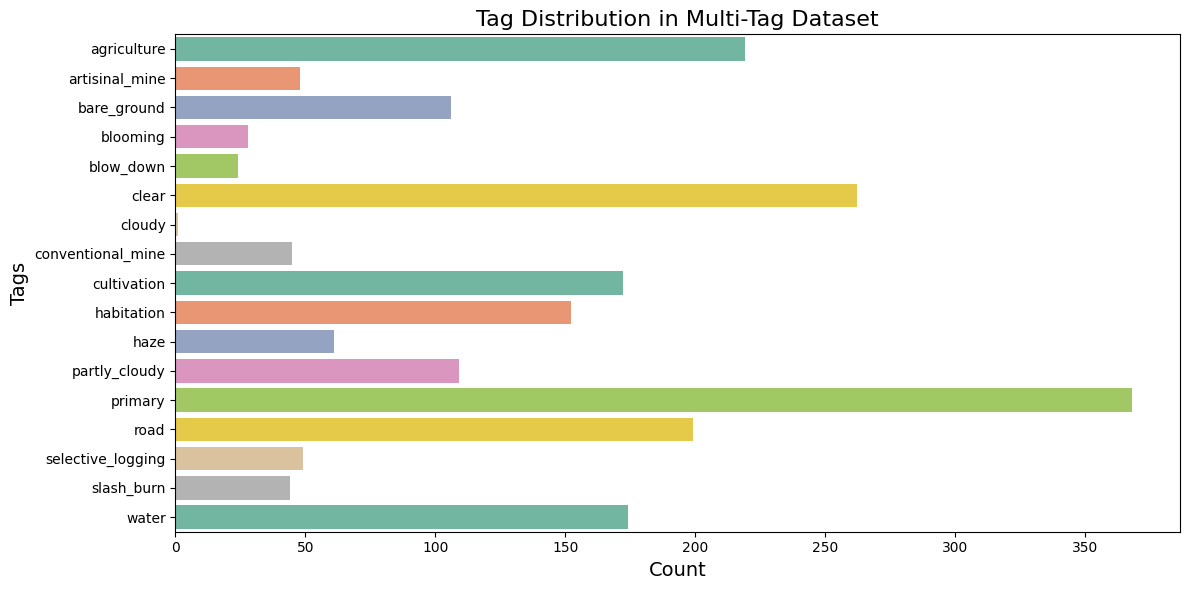

Standard Deviation of Tag Frequencies: 601.5893882545564
IRperLabel: {'blooming': 0.06451612903225806, 'road': 0.45852534562211983, 'partly_cloudy': 0.2511520737327189, 'slash_burn': 0.10138248847926268, 'blow_down': 0.05069124423963134, 'cloudy': 0.002304147465437788, 'agriculture': 0.5046082949308756, 'haze': 0.14055299539170507, 'habitation': 0.35023041474654376, 'bare_ground': 0.24423963133640553, 'clear': 0.6036866359447005, 'primary': 0.847926267281106, 'artisinal_mine': 0.11059907834101383, 'selective_logging': 0.11290322580645161, 'water': 0.4009216589861751, 'conventional_mine': 0.10368663594470046, 'cultivation': 0.35253456221198154}
MeanIR: 0.2764976958525346
CVIR: 0.80944183140691


In [190]:
plot_spread(df_undersampled)
get_std_dev(df_undersampled)
IR = calculate_IRperLabel(all_tags, df_undersampled)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

## Oversampling

### Label Powerset based Random Oversampling (LP-ROS)

In [191]:
from imblearn.over_sampling import RandomOverSampler

# Apply random oversampling
ros = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = ros.fit_resample(X_transformed, y_transformed)

df_oversampled = pd.DataFrame(X_oversampled)

# Add the decoded labels as a column to the DataFrame
df_oversampled['tags'] = y_oversampled
print(df_oversampled)

                   0                                    tags
0        train_21859                           clear primary
1        train_14965  agriculture partly_cloudy primary road
2        train_13159                           clear primary
3        train_38804                                  cloudy
4        train_35253                     clear primary water
...              ...                                     ...
5312155  train_24448                                   water
5312156  train_24448                                   water
5312157  train_24448                                   water
5312158  train_24448                                   water
5312159  train_24448                                   water

[5312160 rows x 2 columns]


C:\Users\xxpur\AppData\Local\Temp\ipykernel_32304\2573084261.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


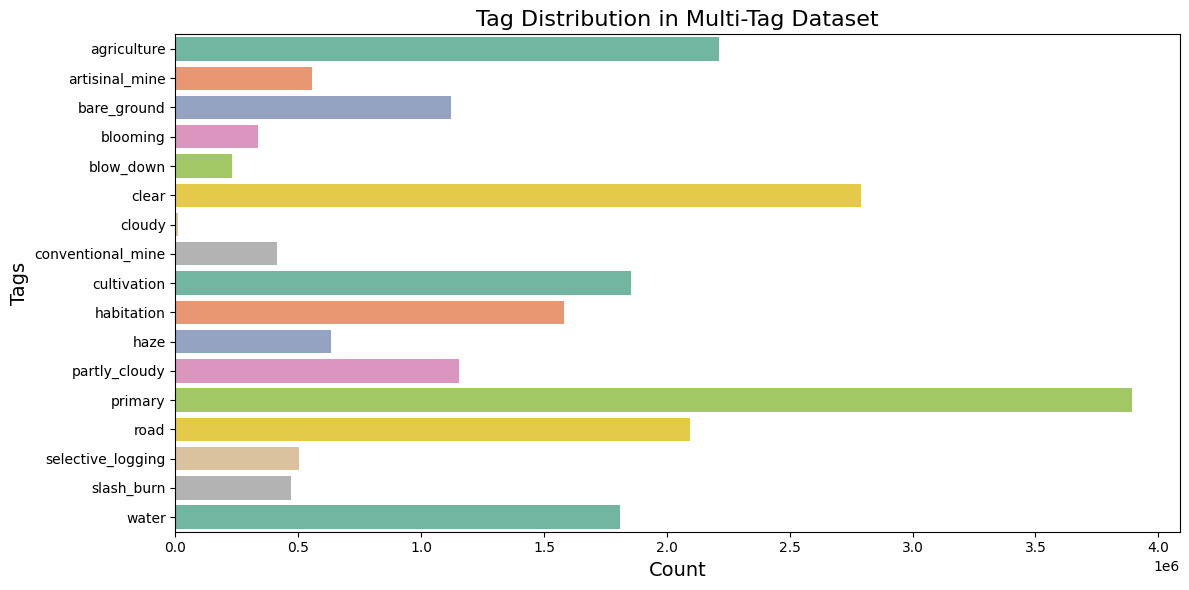

Standard Deviation of Tag Frequencies: 6321737.504295572


In [160]:
plot_spread(df_oversampled)
get_std_dev(df_oversampled)
# IR = calculate_IRperLabel(all_tags, df_oversampled)
# MeanIR = calculate_MeanIR(IR)
# CVIR = calculate_CVIR(IR, MeanIR)

# print("IRperLabel:", IR)
# print("MeanIR:", MeanIR)
# print("CVIR:", CVIR)

### SMOTE

In [ ]:
# Taken from https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote 

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

# Testing

In [192]:
# ResNet & DenseNet
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# EfficientNet_b1
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [207]:
dataset = MultiLabelImageDataset(df_oversampled, img_dir="data/planet\planet/train-jpg", transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
# Since valiation split already done above with original data so no need

# # Only quick testing
#train_idx_small = train_idx[:1000]  # First 1000 training samples
#test_idx_small = test_idx[:200]  # First 200 testing samples

#train_idx_small = train_idx[:32787] 
#test_idx_small = test_idx[:3644] 

#train_dataset = Subset(dataset, train_idx_small)
#test_dataset = Subset(dataset, test_idx_small)
train_dataset = Subset(dataset, list(range(len(df_oversampled))))
val_dataset = MultiLabelImageDataset(val, img_dir="data/planet\planet/train-jpg", transform=transform)
val_dataset = Subset(val_dataset, list(range(len(val))))

#train_dataset = Subset(dataset, train_idx)
#test_dataset = Subset(dataset, test_idx)

print(len(train_idx))
print(len(test_idx))



batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

4780944
531216


In [164]:
import torchvision.models as models
from torch import nn

num_classes = 17

def EfficientNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.efficientnet_b1(weights='DEFAULT')
    # num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(1280, num_classes)
    return model_ft

In [165]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = EfficientNetClassifier(num_classes)
model.to(device)
#model

Using cuda device


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [209]:
def train_loop(dataloader, val_dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 64 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        if batch % 256 == 0:
            val_loop(val_dataloader, model, loss_fn)


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    test_loss /= num_batches
    f2 /= num_batches
    
    print(f"Test Error: \n f2 score: {f2:.5f}, avg loss: {test_loss:>8f} \n")
    return f2, test_loss

def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    val_loss /= num_batches
    f2 /= num_batches
    
    print(f"Val Error: \n f2 score: {f2:.5f}, avg loss: {val_loss:>8f} \n")
    return f2, val_loss


In [211]:
learning_rate = 0.0001
epochs = 5

In [212]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
all_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, val_dataloader, model, loss_fn, optimizer)
    #f2, test_loss = test_loop(test_dataloader, model, loss_fn)
    #val_loop(val_dataloader, model, loss_fn)
    #all_loss.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.054668  [    8/5312160]
Val Error: 
 f2 score: 0.84592, avg loss: 0.189879 

loss: 0.033064  [  520/5312160]
loss: 0.003390  [ 1032/5312160]
loss: 0.003472  [ 1544/5312160]
loss: 0.096178  [ 2056/5312160]
Val Error: 
 f2 score: 0.87272, avg loss: 0.160797 

loss: 0.025181  [ 2568/5312160]
loss: 0.009137  [ 3080/5312160]
loss: 0.001747  [ 3592/5312160]
loss: 0.003940  [ 4104/5312160]
Val Error: 
 f2 score: 0.87146, avg loss: 0.158228 

loss: 0.019376  [ 4616/5312160]
loss: 0.001292  [ 5128/5312160]
loss: 0.000199  [ 5640/5312160]
loss: 0.001818  [ 6152/5312160]
Val Error: 
 f2 score: 0.86871, avg loss: 0.170038 

loss: 0.108952  [ 6664/5312160]
loss: 0.030832  [ 7176/5312160]
loss: 0.000563  [ 7688/5312160]
loss: 0.028221  [ 8200/5312160]
Val Error: 
 f2 score: 0.87694, avg loss: 0.155587 

loss: 0.000853  [ 8712/5312160]
loss: 0.003213  [ 9224/5312160]
loss: 0.001964  [ 9736/5312160]
loss: 0.022177  [10248/5312160]
Val Error: 
 f2 score: 

KeyboardInterrupt: 